<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Final Research Assignment
---

### Project Background:
I have been using a budgeting tool for almost 9 years to manage all of my financial accounts and budget. Every account I’ve had since 2012 has been connected so it has all of my transactions. The software automatically categorizes your transactions into predetermined budget categories (groceries, shopping, rent, etc).<br>
Presumably, the software uses some type of machine learning algorithm to classify the transaction into a budget category. For the most part it does a decent job but every month there are quite a few transactions that I need to manually change to the correct category. 

###Problem statement:
I think it would be really interesting to attempt to use a DNN to read the text description and attempt to do my own category classification. I could then compare against the software's preassigned data going forward and see whether I can get close to matching it's accuracy.

<i>Notebook run in Colab with TPUs (Total Runtime: ~10min)</i>

## Administrative Setup
***

In [1]:
import datetime
from datetime import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn import model_selection
import sklearn
from sklearn.metrics import classification_report


# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import tensorflow_datasets as tfds

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.4.1


In [4]:
print("Keras version: ", keras.__version__)

Keras version:  2.4.0


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [5]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [6]:
seed = 1234

## Loading Data
***

This data is an export from my personal budgeting software. I have transaction data from all of my accounts going back almost 9 years.<br><br> 
I've done some cleaning of the data in Excel on my local computer to take out and personally identifable information (for example removing any account numbers or names) as well as removing unnecessary columns (date, transaction amount, etc). <br><br>
What I am uploading here are two fields: 
* Description: Text field from the bank on the transaction vender (example: Home Depot)
* Category: The budget category assigned by my budget software (example: Groceries).

In [7]:
df = pd.read_excel("descriptions.xlsx", sheet_name='edited')

In [8]:
df.loc[10:30]

,Description,Category
10,Target,Kids
11,Wal-Mart,Shopping
12,Interest Paid,Interest Income
13,ComEd,Utilities
14,LOFT,Shopping - R
15,Bed Bath & Beyond,Shopping - R
16,Amazon,Pharmacy
17,Amazon,Home
18,Target,Home
19,College Savings ACH,529 Plan


## EDA
***

In [9]:
# We have 8k transactions
len(df)

8349

Let's learn some more about our target field [Category]

In [11]:
# Determining how many distinct categories exist
print("Number of unique categories: ", len(np.unique(df.loc[:,'Category'])))

Number of unique categories:  101


In [12]:
# Checking the top 20 categories
df.value_counts(df.loc[:,'Category'])[:20]

Category
Alcohol & Bars         1017
Restaurants             866
Groceries               524
Transfer                512
Gas & Fuel              438
Gift                    407
Shopping                402
Credit Card Payment     368
Interest Income         282
Paycheck                247
Utilities               213
Home Improvement        187
Fast Food               186
Clothing                186
Income                  143
Student Loan            135
Rental Car and Taxi     135
Hobbies                 119
Mobile Phone            101
Internet                 96
dtype: int64

In [13]:
df.value_counts(df.loc[:,'Category'])[:20].index

Index(['Alcohol & Bars', 'Restaurants', 'Groceries', 'Transfer', 'Gas & Fuel',
       'Gift', 'Shopping', 'Credit Card Payment', 'Interest Income',
       'Paycheck', 'Utilities', 'Home Improvement', 'Fast Food', 'Clothing',
       'Income', 'Student Loan', 'Rental Car and Taxi', 'Hobbies',
       'Mobile Phone', 'Internet'],
      dtype='object', name='Category')

<BarContainer object of 20 artists>

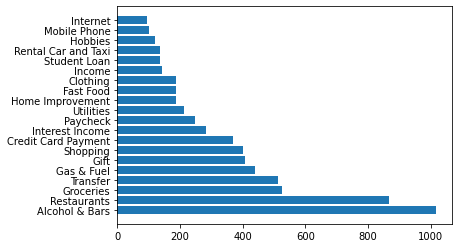

In [14]:
# Plotting the top 20 categories
plt.barh(df.value_counts(df.loc[:,'Category'])[:20].index, df.value_counts(df.loc[:,'Category'])[:20])

Keep in mind these are counts of transactions. And this time period covers my first few years post college, don't judge on the top categories :)


100 categories is a lot to try to predict. Based on the bar chart above perhaps we can just use the top n categories?

In [15]:
# Checking what percent of records are captured by the top n categories
n = 20
print("Percent of values in top %d categories: "%n,sum(df.value_counts(df.loc[:,'Category'])[:n])/len(df))
print("Number of records in top %d categories: "%n,sum(df.value_counts(df.loc[:,'Category'])[:n]))

Percent of values in top 20 categories:  0.786201940352138
Number of records in top 20 categories:  6564


In [16]:
# 
n_list = []
for n in range(1,51):
  n_list.append(sum(df.value_counts(df.loc[:,'Category'])[:n])/len(df))

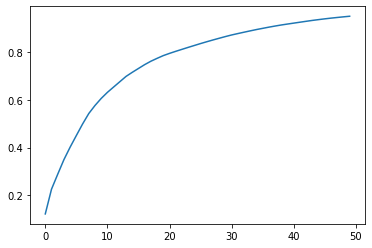

In [17]:
# Checking what percent of records are captured by the top n categories
plt.plot(n_list)

Based on the pareto above we can see that by using the top 20 categories cover almost 80% of the records. <br><br>
We don't see a very crisp flatline, it slowly tapers as n approaches 50. I think using the top 20 categories is a good compromise. Not too many categories but still enough that we aren't losing too many records.

In [18]:
# Filtering for only records in the top 20 categories
top_20 = df.value_counts(df.loc[:,'Category'])[:20].index

df = df.loc[df.loc[:, 'Category'].isin(top_20), :]

In [19]:
# Comfirming we're getting the correct record count after dropping the rows
len(df)

6564

Now lets transition from inspecting the categories to looking at the [Description] field

In [20]:
# Viewing the first 20 descriptions
df.loc[:, 'Description'][:20]

1                      Apple
2                       AT&T
3                       AT&T
4                 Home Depot
6               Cricket Comm
8                   Wal-Mart
11                  Wal-Mart
12             Interest Paid
13                     ComEd
23                  Wal-Mart
25    J WOK CHINESE KITCHEN.
26                Home Depot
29                 Instacart
30                 Instacart
31                Home Depot
32              Fresh Market
39                    MEJURI
41                    Amazon
42       Wall Street Journal
44              Panera Bread
Name: Description, dtype: object

In [21]:
# Checking the top 20 Descriptions
df.value_counts(df.loc[:,'Description'])[:20]

Description
Amazon                                300
Interest Paid                         251
Aldi                                  183
Hk Payrol Payroll                     165
Uber.com                              131
Transfer from Interest Checking       121
Spring                                105
Home Depot                             81
Target                                 79
Echeck Deposit                         77
Fresh Market                           73
ComEd                                  72
Wal-Mart                               71
Casey's                                70
Jewel                                  70
McDonald's                             69
Cgb Enterprise Direct                  69
Transfer to Online Savings Account     68
Shell                                  66
Verizon Wireless                       66
dtype: int64

## Vectorizing and Embedding Text
***
Here I'll focus on translating the text into vectors that our models can use. I'll be using Tensorflow's TextVectorization Layer. 

https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization


Before doing that however I'll need to do some further EDA on the embeddings. Mainly I'll be looking to answer two questions that will affect our modeling:

1. Should we cap the number of tokens per document?
2. What should be the vocabulary size?

In [22]:
# Performing text vectorization then getting the vocab set
%%time
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=None)
encoder.adapt(np.array(df.loc[:,'Description']))

vocab = np.array(encoder.get_vocabulary())

CPU times: user 72.6 ms, sys: 31.4 ms, total: 104 ms
Wall time: 355 ms


In [23]:
# Checking top 20 tokens
vocab[:20]

array(['', '[UNK]', 'transfer', 'interest', 'amazon', 'from', 'checking',
       'to', 'paid', 'savings', 'rf', 'account', 'online', 'aldi',
       'payroll', 'hk', 'chase', 'payrol', 'ubercom', 'spring'],
      dtype='<U21')

In [24]:
# Checking the bottom 30 least common words
print(vocab[-30:])

['1077' '1076' '1063' '1058' '1057' '1051' '1047' '1045' '1043' '1042'
 '1040' '1039' '1037' '1032' '103' '1029' '1024' '1022' '1021' '1020'
 '1019' '1018' '1017' '1016' '100th' '10' '0580' '0319' '03' '0170']


In [ ]:
# Creating a tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices(df)
list(dataset.as_numpy_iterator())

In [26]:
# Now let's run our Training set through the encoder to do some more EDA
%%time
doc_sizes = []
corpus = []
for example, _ in dataset.as_numpy_iterator():
  enc_example = encoder(example)
  doc_sizes.append(len(enc_example))
  corpus+=list(enc_example.numpy())

CPU times: user 16.1 s, sys: 89.4 ms, total: 16.2 s
Wall time: 16.2 s


In [27]:
# Checking high level metrics
print("Number of Words: \t\t", len(corpus))
print("Number of Documents: \t\t", len(doc_sizes))
print("Minimum Words in a document: \t", min(doc_sizes))
print("Maximum Words in a document: \t", max(doc_sizes))

Number of Words: 		 14398
Number of Documents: 		 6564
Minimum Words in a document: 	 1
Maximum Words in a document: 	 10


1. Should we cap the number of tokens per document?

Text(0, 0.5, 'Number of Transactions')

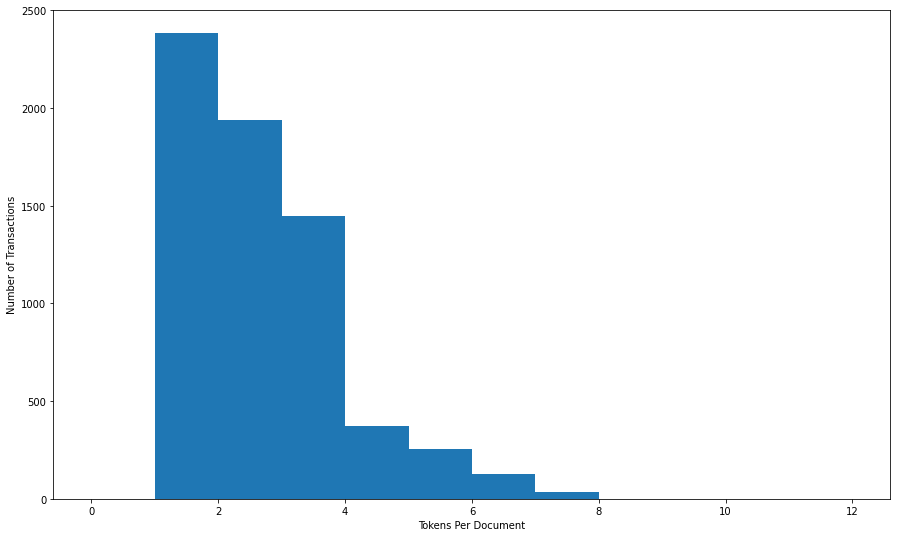

In [28]:
# Viewing histogram of the number of words per transaction
plt.figure(figsize=(15,9))
plt.hist(doc_sizes, bins=12,range = (0,12))
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of Transactions")

In [111]:
# Checking what percent of documents have less than n words
n = 3
print("{0:.1%} of documents have".format(sum(i <= n for i in doc_sizes)/ len(doc_sizes)), n, "or less words")

88.0% of documents have 3 or less words


If we cap the output_sequence_length to 3 we're getting all of the words in 88% of the documents and truncating 12% of the documents. However I think we need as much signal as we can get, I don't see a reason to cap. Speed won't be an issue with such a small data set.

2. What should be the vocabulary size?

In [30]:
# Checking number of words in our corpus
len(vocab)

2039

There are currently ~2,000 distinct tokens. That's pretty small, I see no reason to restrict this. Speed won't be an issue with this amount of tokens.

## Final Data Prep

In [116]:
# Creating a dictionary with the Categories and a number value for each
# Used for encoding
d = dict(zip(top_20, range(0, 20)))
d

{'Alcohol & Bars': 0,
 'Clothing': 13,
 'Credit Card Payment': 7,
 'Fast Food': 12,
 'Gas & Fuel': 4,
 'Gift': 5,
 'Groceries': 2,
 'Hobbies': 17,
 'Home Improvement': 11,
 'Income': 14,
 'Interest Income': 8,
 'Internet': 19,
 'Mobile Phone': 18,
 'Paycheck': 9,
 'Rental Car and Taxi': 16,
 'Restaurants': 1,
 'Shopping': 6,
 'Student Loan': 15,
 'Transfer': 3,
 'Utilities': 10}

In [32]:
# Creating a numerical encoding for each category
df.loc[:,'Label'] = df['Category'].map(d, na_action='ignore')

In [33]:
# Shuffle data
train_data = df.sample(frac=1)

In [34]:
# Create datasets
X_train = train_data[0:round(len(df)*0.9)]['Description']
X_validate = train_data[round(len(df)*0.9): round(len(df)*0.95) ]['Description']
X_test = train_data[round(len(df)*0.95):]['Description']

Y_train = train_data[0:round(len(df)*0.9)]['Label']
Y_validate = train_data[round(len(df)*0.9): round(len(df)*0.95) ]['Label']
Y_test = train_data[round(len(df)*0.95):]['Label']

In [35]:
# Convert data to numpy array
X_train = X_train.to_numpy()
X_validate = X_validate.to_numpy()
X_test = X_test.to_numpy()

Y_train = Y_train.to_numpy()
Y_validate = Y_validate.to_numpy()
Y_test = Y_test.to_numpy()

In [36]:
# Create an encoder.
# It will take a single document (string) as an input, and it will
# integer encode the document, returning a dense array of integers.
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
max_tokens=None, standardize='lower_and_strip_punctuation',
split='whitespace', ngrams=None, output_mode='int',
output_sequence_length=None, pad_to_max_tokens=True)


# Fit the encoder with the train dataset
encoder.adapt(X_train)


## Modeling 

### Helper Functions

We'll start with a few functions to make things easier to repeat. 
In order to be able to compare across experiments we'll keep some parameters the same. To do this we'll use some formulas so that all of our models compile and fit the same way.
We will also want to print all of the results and record the time it takes the models to run.

In [37]:
# Checking the null model accuracy (if we just predicted the majority class every time)
len(df.loc[df.loc[:, 'Label'] == 0, :])/len(df)

0.15493601462522852

So for any model to be meaningful it needs to AT LEAST beat 15% accuracy.

In [39]:
# Creating a function to compile and fit models
def compile_and_fit(model_n, weights = None, metrics = ['accuracy']):
  start = datetime.now()
  model_n.compile(
              optimizer=tf.keras.optimizers.Adam(lr=1e-3)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy()
              ,metrics=metrics)
  history_n = model_n.fit(x = X_train
              ,y = Y_train
              ,epochs = 20
              ,validation_data = (X_validate, Y_validate)
              ,class_weight = weights 
                    )
  end = datetime.now()
  time_n = end - start
  return history_n, time_n

In [40]:
# Creating a function to allow for easier plotting of loss and accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [41]:
# Creating a function to easily plot a confusion matrix
def confusion_matrix(model):
  pred_classes = np.argmax(model.predict(X_validate), axis=-1)
  conf_mx = tf.math.confusion_matrix(Y_validate, pred_classes)
  plt.figure(figsize=(16,8))
  plt.matshow(conf_mx, cmap=plt.cm.Blues,fignum=1)
  plt.xlabel("Predicted Classes")
  plt.ylabel("Actual Classes")
  return plt.show()

### 1. Simple RNN

In [42]:
# Starting with a simple RNN
model_1 = tf.keras.Sequential([
                               tf.keras.Input(shape=(1,), dtype=tf.string)
                              ,encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                              ,output_dim=32)
                              ,tf.keras.layers.SimpleRNN(32)
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(20,activation='softmax')
])

In [43]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 32)          61312     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1300      
Total params: 66,804
Trainable params: 66,804
Non-trainable params: 0
_________________________________________________________________


In [44]:
history_1, time_1 = compile_and_fit(model_1)

Epoch 1/20
185/185 [==============================] - 2s 6ms/step - loss: 2.6015 - accuracy: 0.2181 - val_loss: 1.3114 - val_accuracy: 0.6067
Epoch 2/20
185/185 [==============================] - 1s 3ms/step - loss: 1.1700 - accuracy: 0.6536 - val_loss: 1.0791 - val_accuracy: 0.6890
Epoch 3/20
185/185 [==============================] - 1s 3ms/step - loss: 0.8371 - accuracy: 0.7446 - val_loss: 1.0911 - val_accuracy: 0.6890
Epoch 4/20
185/185 [==============================] - 1s 3ms/step - loss: 0.6987 - accuracy: 0.7856 - val_loss: 1.0517 - val_accuracy: 0.7256
Epoch 5/20
185/185 [==============================] - 1s 3ms/step - loss: 0.6131 - accuracy: 0.8086 - val_loss: 1.0474 - val_accuracy: 0.7134
Epoch 6/20
185/185 [==============================] - 1s 3ms/step - loss: 0.5568 - accuracy: 0.8181 - val_loss: 1.0485 - val_accuracy: 0.7256
Epoch 7/20
185/185 [==============================] - 1s 3ms/step - loss: 0.5175 - accuracy: 0.8174 - val_loss: 1.0637 - val_accuracy: 0.7165
Epoch 

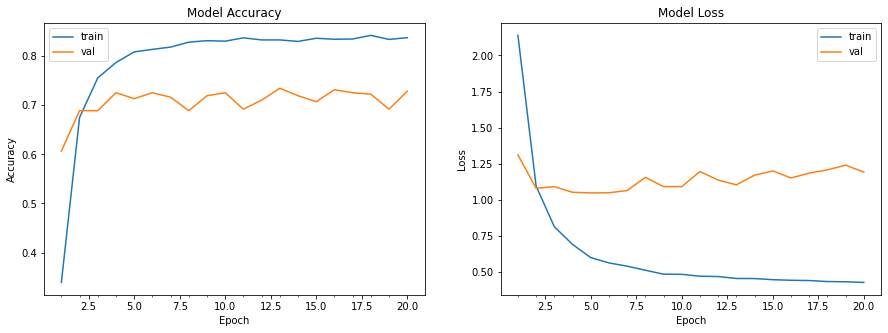

In [45]:
plot_model_history(history_1)

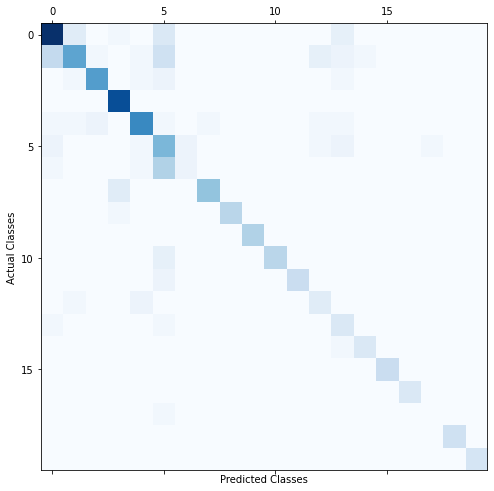

In [46]:
confusion_matrix(model_1)

### 2. Simple RNN - with Bias
One thing I noticed early on during EDA was the imbalance among our classes. Let's try adding some bias to account for this.

In [47]:
# Generating weights for dealing with imbalance
weights = []
for i in range(0, 20):
  weight_for_i = (1 / len(df.loc[df.loc[:,'Label'] == i, :]))*(len(df))/20 
  weights.append(weight_for_i)

#class_weight = {0: weight_for_0, 1: weight_for_1}


In [48]:
class_weight = dict(zip(d.values(), weights))
class_weight

{0: 0.32271386430678467,
 1: 0.3789838337182448,
 2: 0.6263358778625954,
 3: 0.641015625,
 4: 0.7493150684931507,
 5: 0.8063882063882064,
 6: 0.8164179104477611,
 7: 0.8918478260869565,
 8: 1.1638297872340426,
 9: 1.3287449392712551,
 10: 1.5408450704225352,
 11: 1.7550802139037434,
 12: 1.7645161290322584,
 13: 1.7645161290322584,
 14: 2.295104895104895,
 15: 2.4311111111111114,
 16: 2.4311111111111114,
 17: 2.757983193277311,
 18: 3.2495049504950493,
 19: 3.41875}

In [50]:
# Building our same simple RNN

model_2 = tf.keras.Sequential([
                               tf.keras.Input(shape=(1,), dtype=tf.string)
                              ,encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                              ,output_dim=32)
                              ,tf.keras.layers.SimpleRNN(32)
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(20,activation='softmax')
])

In [51]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 32)          61312     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1300      
Total params: 66,804
Trainable params: 66,804
Non-trainable params: 0
_________________________________________________________________


In [52]:
# Using our bias weights this time

history_2, time_2 = compile_and_fit(model_2, weights = class_weight)

Epoch 1/20
185/185 [==============================] - 2s 4ms/step - loss: 2.7521 - accuracy: 0.1578 - val_loss: 1.6187 - val_accuracy: 0.5091
Epoch 2/20
185/185 [==============================] - 1s 3ms/step - loss: 1.1479 - accuracy: 0.6003 - val_loss: 1.2141 - val_accuracy: 0.6890
Epoch 3/20
185/185 [==============================] - 1s 3ms/step - loss: 0.7389 - accuracy: 0.7447 - val_loss: 1.3502 - val_accuracy: 0.6707
Epoch 4/20
185/185 [==============================] - 1s 3ms/step - loss: 0.5770 - accuracy: 0.7929 - val_loss: 1.1587 - val_accuracy: 0.6890
Epoch 5/20
185/185 [==============================] - 1s 3ms/step - loss: 0.4997 - accuracy: 0.8107 - val_loss: 1.2230 - val_accuracy: 0.6707
Epoch 6/20
185/185 [==============================] - 1s 3ms/step - loss: 0.4436 - accuracy: 0.8143 - val_loss: 1.2354 - val_accuracy: 0.6829
Epoch 7/20
185/185 [==============================] - 1s 3ms/step - loss: 0.4484 - accuracy: 0.8165 - val_loss: 1.1510 - val_accuracy: 0.7012
Epoch 

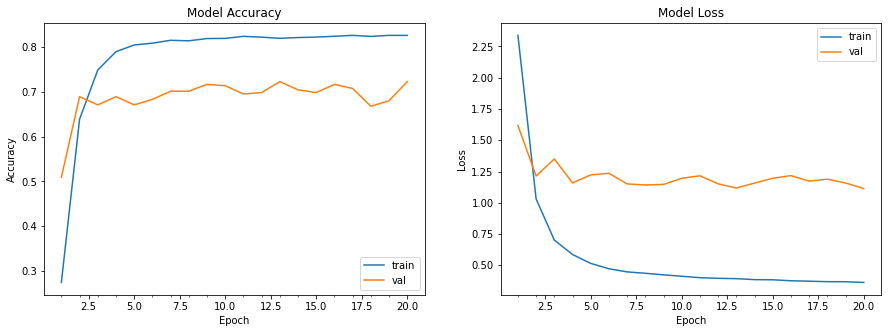

In [53]:
plot_model_history(history_2)

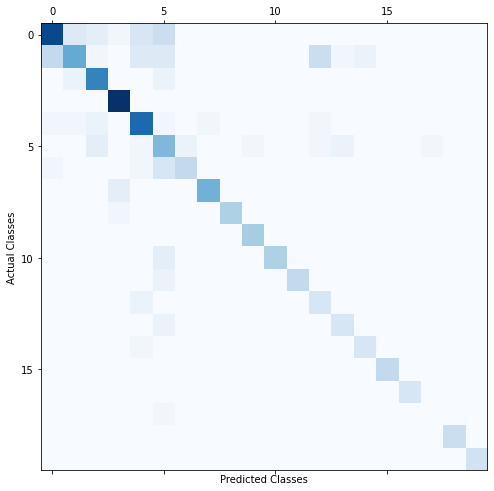

In [54]:
confusion_matrix(model_2)

### 3. Simple RNN - With normalization (regularization, dropout, batch_normalization)
Another concern is overfitting since we're dealing with such a small dataset. One approach for dealing with this is to add in different normalization methods. We'll test what effect this has here.

In [55]:
# Adding normalization to our simple RNN
model_3 = tf.keras.Sequential([
                               tf.keras.Input(shape=(1,), dtype=tf.string)
                              ,encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                              ,output_dim=32)
                              ,tf.keras.layers.BatchNormalization()
                              ,tf.keras.layers.SimpleRNN(32, kernel_regularizer=regularizers.l2(0.0001))
                              ,tf.keras.layers.Dropout(0.25)
                              ,tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001))
                              ,tf.keras.layers.Dense(20,activation='softmax')
])

In [56]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, None)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 32)          61312     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 32)          128       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_5 (Dense)              (None, 20)               

In [57]:
history_3, time_3 = compile_and_fit(model_3)

Epoch 1/20
185/185 [==============================] - 2s 5ms/step - loss: 2.6593 - accuracy: 0.1931 - val_loss: 2.0850 - val_accuracy: 0.3689
Epoch 2/20
185/185 [==============================] - 1s 3ms/step - loss: 1.4489 - accuracy: 0.5602 - val_loss: 1.3471 - val_accuracy: 0.5793
Epoch 3/20
185/185 [==============================] - 1s 3ms/step - loss: 0.9561 - accuracy: 0.7192 - val_loss: 1.1553 - val_accuracy: 0.7165
Epoch 4/20
185/185 [==============================] - 1s 3ms/step - loss: 0.8106 - accuracy: 0.7665 - val_loss: 1.0776 - val_accuracy: 0.7195
Epoch 5/20
185/185 [==============================] - 1s 3ms/step - loss: 0.6941 - accuracy: 0.7861 - val_loss: 1.0736 - val_accuracy: 0.7195
Epoch 6/20
185/185 [==============================] - 1s 3ms/step - loss: 0.6531 - accuracy: 0.7926 - val_loss: 1.1132 - val_accuracy: 0.7195
Epoch 7/20
185/185 [==============================] - 1s 3ms/step - loss: 0.6004 - accuracy: 0.7957 - val_loss: 1.0790 - val_accuracy: 0.7409
Epoch 

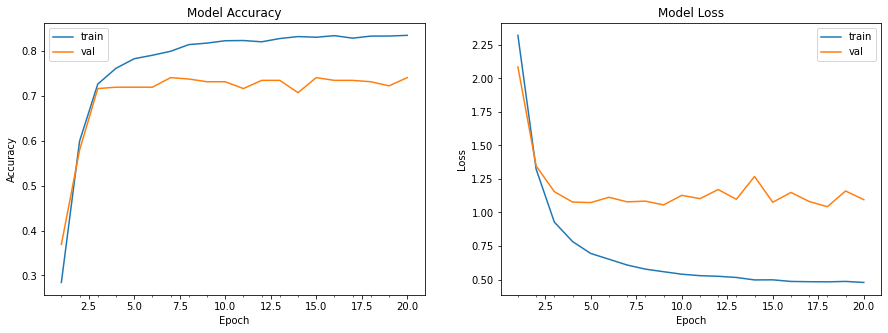

In [58]:
plot_model_history(history_3)

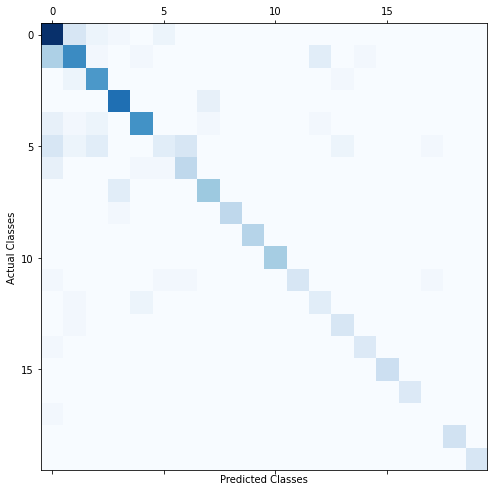

In [59]:
confusion_matrix(model_3)

### 4. Simple RNN - with Bias AND Regularization
Lastly for our RNN let's see how including both normalization and bias effects the accuracy.

In [60]:
# Using our same RNN with normalization
model_4 = tf.keras.Sequential([
                               tf.keras.Input(shape=(1,), dtype=tf.string)
                              ,encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                              ,output_dim=32)
                              ,tf.keras.layers.BatchNormalization()
                              ,tf.keras.layers.SimpleRNN(32, kernel_regularizer=regularizers.l2(0.0001))
                              ,tf.keras.layers.Dropout(0.25)
                              ,tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001))
                              ,tf.keras.layers.Dense(20,activation='softmax')
])

In [61]:
# Including bias weights
history_4, time_4 = compile_and_fit(model_4, weights = class_weight)

Epoch 1/20
185/185 [==============================] - 2s 5ms/step - loss: 2.8103 - accuracy: 0.1168 - val_loss: 2.4001 - val_accuracy: 0.3567
Epoch 2/20
185/185 [==============================] - 1s 3ms/step - loss: 1.6912 - accuracy: 0.4574 - val_loss: 1.5036 - val_accuracy: 0.5671
Epoch 3/20
185/185 [==============================] - 1s 3ms/step - loss: 1.0288 - accuracy: 0.6222 - val_loss: 1.2879 - val_accuracy: 0.6311
Epoch 4/20
185/185 [==============================] - 1s 3ms/step - loss: 0.8172 - accuracy: 0.6998 - val_loss: 1.2863 - val_accuracy: 0.6463
Epoch 5/20
185/185 [==============================] - 1s 3ms/step - loss: 0.7286 - accuracy: 0.7456 - val_loss: 1.1985 - val_accuracy: 0.6860
Epoch 6/20
185/185 [==============================] - 1s 3ms/step - loss: 0.6096 - accuracy: 0.7839 - val_loss: 1.1338 - val_accuracy: 0.7104
Epoch 7/20
185/185 [==============================] - 1s 3ms/step - loss: 0.5513 - accuracy: 0.7943 - val_loss: 1.1411 - val_accuracy: 0.7104
Epoch 

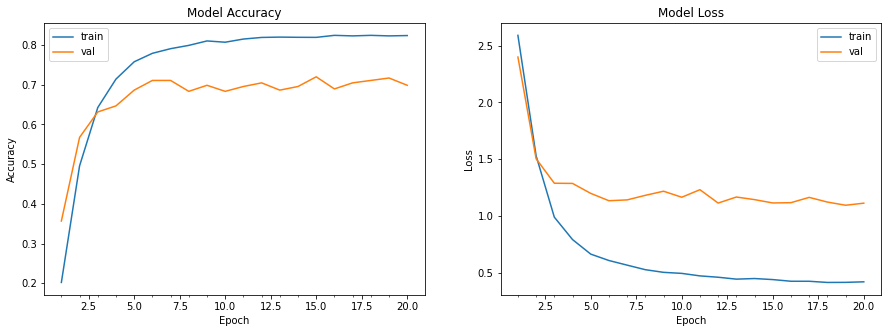

In [62]:
plot_model_history(history_4)

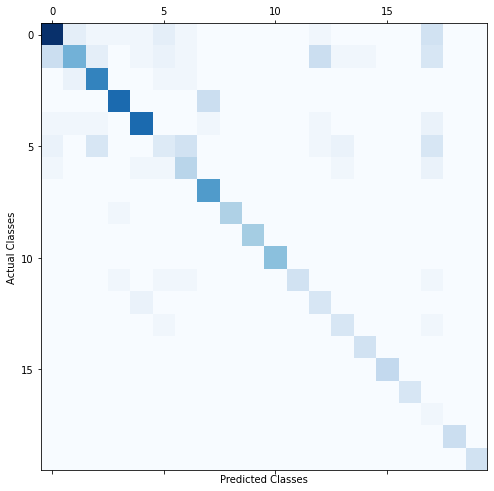

In [63]:
confusion_matrix(model_4)

### 5. Bidirectional LSTM with Normalization
Next let's try a different RNN model: a LSTM model. Normalization added value in the RNN so lets start by including normalization in this model.

In [64]:
# LSTM
model_5 = tf.keras.Sequential([
                               tf.keras.Input(shape=(1,), dtype=tf.string)
                              ,encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                              ,output_dim=32)
                              ,tf.keras.layers.BatchNormalization()
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, kernel_regularizer=regularizers.l2(0.0001)))
                              ,tf.keras.layers.Dropout(0.25)
                              ,tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001))
                              ,tf.keras.layers.Dense(20,activation='softmax')
])

In [65]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, None)              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, None, 32)          61312     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 32)          128       
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 20)               

In [66]:
history_5, time_5 = compile_and_fit(model_5)

Epoch 1/20
185/185 [==============================] - 6s 12ms/step - loss: 2.2615 - accuracy: 0.3210 - val_loss: 2.4048 - val_accuracy: 0.4299
Epoch 2/20
185/185 [==============================] - 1s 7ms/step - loss: 0.7961 - accuracy: 0.7563 - val_loss: 1.4511 - val_accuracy: 0.6524
Epoch 3/20
185/185 [==============================] - 1s 8ms/step - loss: 0.5987 - accuracy: 0.8036 - val_loss: 0.8687 - val_accuracy: 0.7470
Epoch 4/20
185/185 [==============================] - 1s 8ms/step - loss: 0.5102 - accuracy: 0.8305 - val_loss: 0.9156 - val_accuracy: 0.7409
Epoch 5/20
185/185 [==============================] - 1s 8ms/step - loss: 0.4726 - accuracy: 0.8372 - val_loss: 1.0195 - val_accuracy: 0.7378
Epoch 6/20
185/185 [==============================] - 1s 8ms/step - loss: 0.4600 - accuracy: 0.8397 - val_loss: 1.0047 - val_accuracy: 0.7470
Epoch 7/20
185/185 [==============================] - 1s 8ms/step - loss: 0.4121 - accuracy: 0.8512 - val_loss: 1.0248 - val_accuracy: 0.7470
Epoch

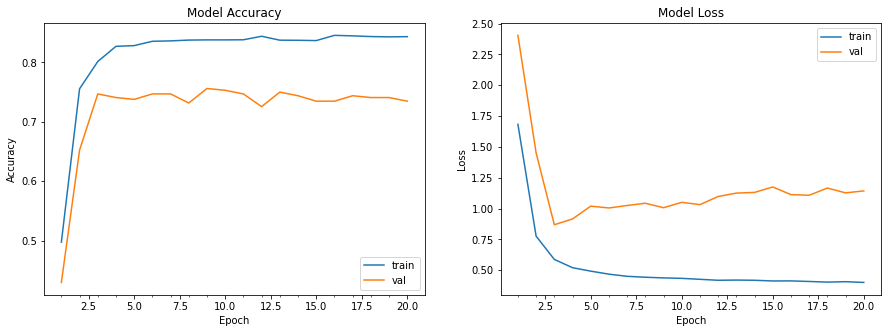

In [67]:
plot_model_history(history_5)

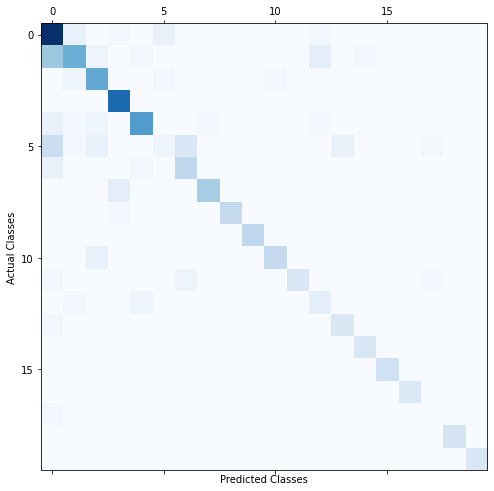

In [68]:
confusion_matrix(model_5)

### 6. Uni-directional LSTM with Normalization
Our text descriptions are short, does the bi-directional layer really make any difference? Testing that hypothesis here.

In [69]:
# LSTM
model_6 = tf.keras.Sequential([
                               tf.keras.Input(shape=(1,), dtype=tf.string)
                              ,encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                              ,output_dim=32)
                              ,tf.keras.layers.BatchNormalization()
                              ,tf.keras.layers.LSTM(64, kernel_regularizer=regularizers.l2(0.0001))
                              ,tf.keras.layers.Dropout(0.25)
                              ,tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001))
                              ,tf.keras.layers.Dense(20,activation='softmax')
])

In [70]:
model_6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, None)              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, None, 32)          61312     
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 32)          128       
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 20)               

In [71]:
history_6, time_6 = compile_and_fit(model_6)

Epoch 1/20
185/185 [==============================] - 4s 10ms/step - loss: 2.4489 - accuracy: 0.2924 - val_loss: 2.1833 - val_accuracy: 0.4848
Epoch 2/20
185/185 [==============================] - 1s 7ms/step - loss: 0.9393 - accuracy: 0.7257 - val_loss: 1.1442 - val_accuracy: 0.6951
Epoch 3/20
185/185 [==============================] - 1s 7ms/step - loss: 0.6537 - accuracy: 0.7976 - val_loss: 0.9465 - val_accuracy: 0.7226
Epoch 4/20
185/185 [==============================] - 1s 8ms/step - loss: 0.5318 - accuracy: 0.8313 - val_loss: 0.9830 - val_accuracy: 0.7073
Epoch 5/20
185/185 [==============================] - 1s 8ms/step - loss: 0.5153 - accuracy: 0.8253 - val_loss: 1.0281 - val_accuracy: 0.7134
Epoch 6/20
185/185 [==============================] - 2s 8ms/step - loss: 0.4670 - accuracy: 0.8363 - val_loss: 1.0366 - val_accuracy: 0.7195
Epoch 7/20
185/185 [==============================] - 2s 8ms/step - loss: 0.4827 - accuracy: 0.8316 - val_loss: 1.0856 - val_accuracy: 0.7134
Epoch

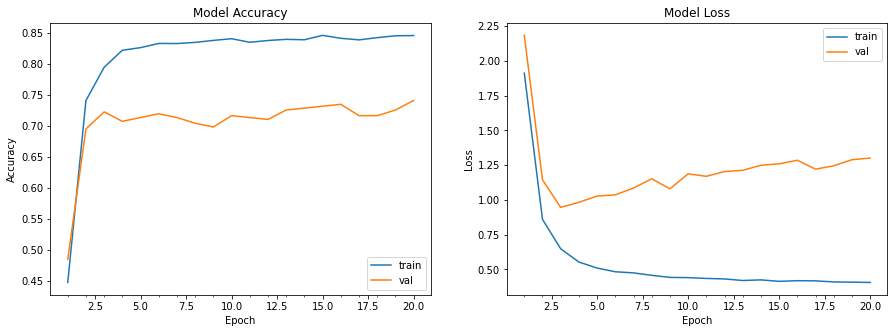

In [72]:
plot_model_history(history_6)

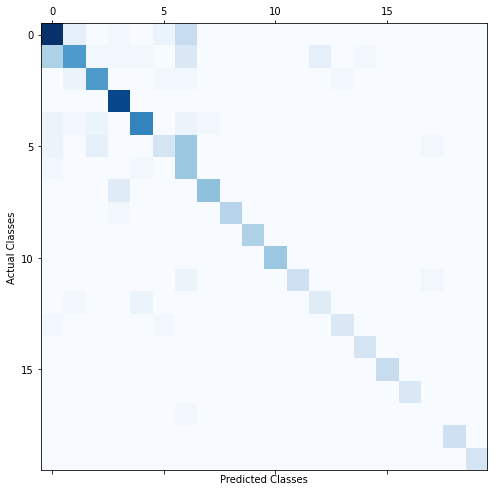

In [73]:
confusion_matrix(model_6)

### 7. Uni-directional LSTM with Normalization and Bias
Now I'm curious what effect adding in our bias weights has on a LSTM model.

In [74]:
# LSTM
model_7 = tf.keras.Sequential([
                               tf.keras.Input(shape=(1,), dtype=tf.string)
                              ,encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                              ,output_dim=32)
                              ,tf.keras.layers.BatchNormalization()
                              ,tf.keras.layers.LSTM(64, kernel_regularizer=regularizers.l2(0.0001))
                              ,tf.keras.layers.Dropout(0.25)
                              ,tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001))
                              ,tf.keras.layers.Dense(20,activation='softmax')
])

In [75]:
history_7, time_7 = compile_and_fit(model_7, weights = class_weight)

Epoch 1/20
185/185 [==============================] - 4s 10ms/step - loss: 2.4617 - accuracy: 0.2754 - val_loss: 2.1660 - val_accuracy: 0.5732
Epoch 2/20
185/185 [==============================] - 1s 7ms/step - loss: 0.8419 - accuracy: 0.6843 - val_loss: 1.3132 - val_accuracy: 0.6982
Epoch 3/20
185/185 [==============================] - 1s 7ms/step - loss: 0.5842 - accuracy: 0.7754 - val_loss: 0.9472 - val_accuracy: 0.7256
Epoch 4/20
185/185 [==============================] - 1s 7ms/step - loss: 0.5026 - accuracy: 0.8017 - val_loss: 0.9226 - val_accuracy: 0.7378
Epoch 5/20
185/185 [==============================] - 1s 7ms/step - loss: 0.4322 - accuracy: 0.8282 - val_loss: 0.9499 - val_accuracy: 0.7256
Epoch 6/20
185/185 [==============================] - 1s 7ms/step - loss: 0.3930 - accuracy: 0.8381 - val_loss: 0.9776 - val_accuracy: 0.7287
Epoch 7/20
185/185 [==============================] - 1s 7ms/step - loss: 0.4304 - accuracy: 0.8166 - val_loss: 0.9800 - val_accuracy: 0.7226
Epoch

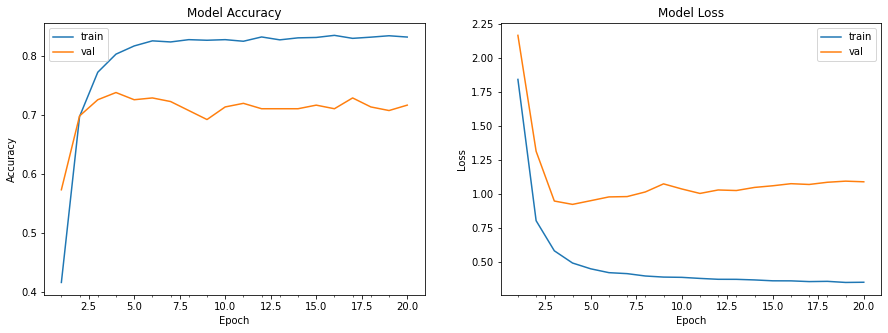

In [76]:
plot_model_history(history_7)

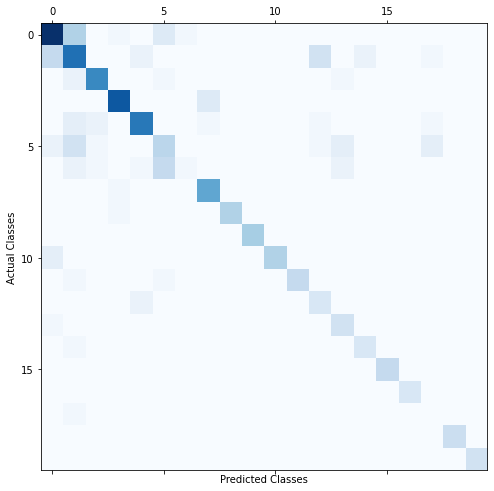

In [77]:
confusion_matrix(model_7)

### 8. 2 Layer Uni-directional LSTM with Normalization and Bias
Can we squeeze out more accuracy by increasing the size/complexity of our model? Testing this by adding another layer.

In [78]:
# LSTM
model_8 = tf.keras.Sequential([
                               tf.keras.Input(shape=(1,), dtype=tf.string)
                              ,encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                              ,output_dim=128, mask_zero=True)
                              ,tf.keras.layers.BatchNormalization()
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, kernel_regularizer=regularizers.l2(0.0001), return_sequences=True))
                              ,tf.keras.layers.Dropout(0.25)
                              ,tf.keras.layers.BatchNormalization()
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, kernel_regularizer=regularizers.l2(0.0001)))
                              ,tf.keras.layers.Dropout(0.25)
                              ,tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001))
                              ,tf.keras.layers.Dense(20,activation='softmax')
])

In [79]:
model_8.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, None)              0         
_________________________________________________________________
embedding_7 (Embedding)      (None, None, 128)         245248    
_________________________________________________________________
batch_normalization_5 (Batch (None, None, 128)         512       
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 256)         263168    
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
batch_normalization_6 (Batch (None, None, 256)         1024      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)              

In [80]:
history_8, time_8 = compile_and_fit(model_8, weights = class_weight)

Epoch 1/20
185/185 [==============================] - 23s 52ms/step - loss: 1.9891 - accuracy: 0.4333 - val_loss: 2.8657 - val_accuracy: 0.3994
Epoch 2/20
185/185 [==============================] - 5s 28ms/step - loss: 0.7574 - accuracy: 0.7353 - val_loss: 1.5616 - val_accuracy: 0.6951
Epoch 3/20
185/185 [==============================] - 5s 29ms/step - loss: 0.5525 - accuracy: 0.8079 - val_loss: 0.9991 - val_accuracy: 0.7317
Epoch 4/20
185/185 [==============================] - 5s 28ms/step - loss: 0.5099 - accuracy: 0.8084 - val_loss: 1.0822 - val_accuracy: 0.7165
Epoch 5/20
185/185 [==============================] - 5s 28ms/step - loss: 0.4643 - accuracy: 0.8185 - val_loss: 1.1043 - val_accuracy: 0.7287
Epoch 6/20
185/185 [==============================] - 5s 29ms/step - loss: 0.4439 - accuracy: 0.8307 - val_loss: 1.0943 - val_accuracy: 0.7256
Epoch 7/20
185/185 [==============================] - 5s 29ms/step - loss: 0.4335 - accuracy: 0.8236 - val_loss: 1.1090 - val_accuracy: 0.716

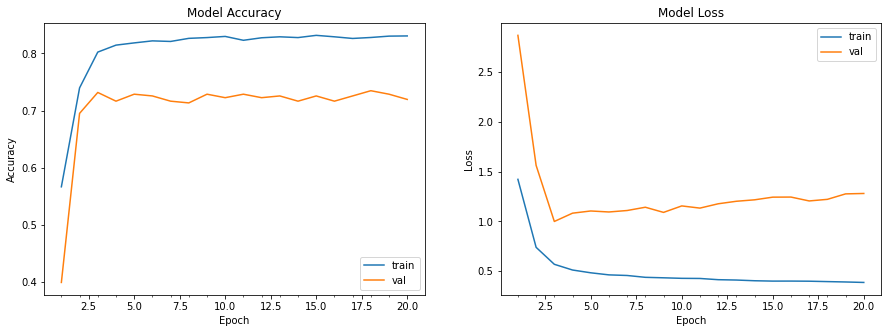

In [81]:
plot_model_history(history_8)

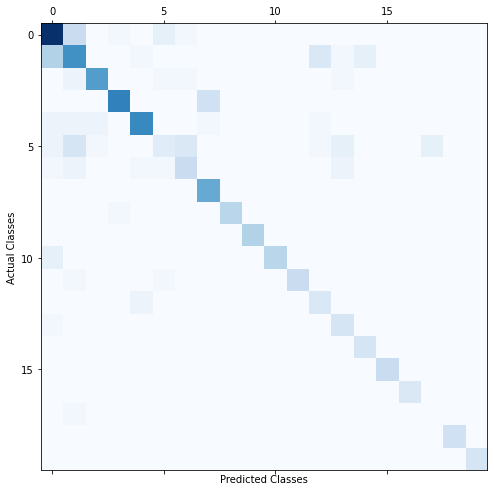

In [82]:
confusion_matrix(model_8)

### 9. 1D ConvNet with Normalization
Another method for text analysis are 1D Convolutional Networks. Let's explore how these perform on this task.

In [83]:
model_9 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                              ,output_dim=64)
                              ,tf.keras.layers.Conv1D(64, 2, activation='relu',padding = 'same', kernel_regularizer=regularizers.l2(0.0001))
                              ,tf.keras.layers.MaxPooling1D(2)
                              ,tf.keras.layers.Dropout(0.25)
                              ,tf.keras.layers.Conv1D(32, 2, activation='relu',padding = 'same', kernel_regularizer=regularizers.l2(0.0001))
                              ,tf.keras.layers.Dropout(0.25)
                              ,tf.keras.layers.GlobalMaxPooling1D()
                              ,tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001))
                              ,tf.keras.layers.Dense(20,activation='softmax')
])

In [84]:
history_9, time_9 = compile_and_fit(model_9)

Epoch 1/20
185/185 [==============================] - 2s 5ms/step - loss: 2.8098 - accuracy: 0.1713 - val_loss: 1.9380 - val_accuracy: 0.4085
Epoch 2/20
185/185 [==============================] - 1s 4ms/step - loss: 1.7309 - accuracy: 0.4561 - val_loss: 1.1655 - val_accuracy: 0.6555
Epoch 3/20
185/185 [==============================] - 1s 4ms/step - loss: 1.0308 - accuracy: 0.6860 - val_loss: 1.0184 - val_accuracy: 0.7226
Epoch 4/20
185/185 [==============================] - 1s 4ms/step - loss: 0.8315 - accuracy: 0.7507 - val_loss: 0.9602 - val_accuracy: 0.7287
Epoch 5/20
185/185 [==============================] - 1s 4ms/step - loss: 0.7136 - accuracy: 0.7726 - val_loss: 0.9729 - val_accuracy: 0.7317
Epoch 6/20
185/185 [==============================] - 1s 4ms/step - loss: 0.6461 - accuracy: 0.7922 - val_loss: 0.9604 - val_accuracy: 0.7378
Epoch 7/20
185/185 [==============================] - 1s 4ms/step - loss: 0.6172 - accuracy: 0.8123 - val_loss: 0.9818 - val_accuracy: 0.7317
Epoch 

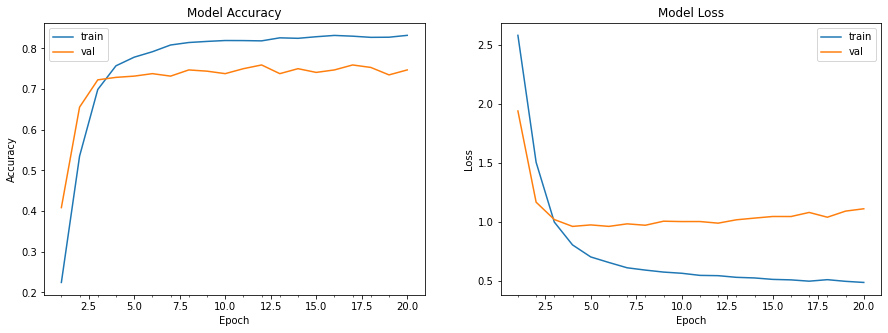

In [85]:
plot_model_history(history_9)

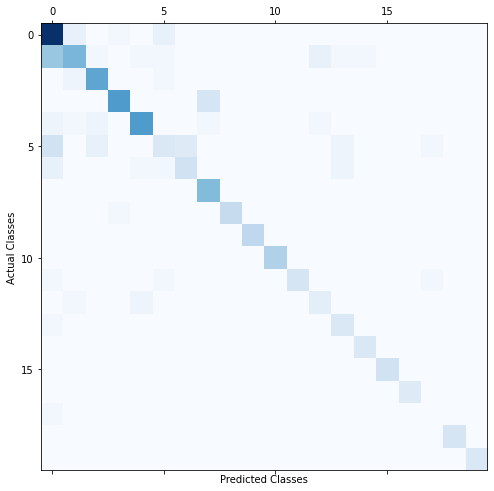

In [86]:
confusion_matrix(model_9)

### 10. Larger 1D ConvNet with Normalization
How about increasing the size/complexity?

In [87]:
model_10 = tf.keras.Sequential([
                               encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                              ,output_dim=128)
                              ,tf.keras.layers.Conv1D(128, 2, activation='relu',padding = 'same', kernel_regularizer=regularizers.l2(0.0001))
                              ,tf.keras.layers.MaxPooling1D(2)
                              ,tf.keras.layers.Dropout(0.25)
                              ,tf.keras.layers.Conv1D(64, 2, activation='relu',padding = 'same', kernel_regularizer=regularizers.l2(0.0001))
                              ,tf.keras.layers.Dropout(0.25)
                              ,tf.keras.layers.GlobalMaxPooling1D()
                              ,tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001))
                              ,tf.keras.layers.Dense(20,activation='softmax')
])

In [88]:
history_10, time_10 = compile_and_fit(model_10)

Epoch 1/20
185/185 [==============================] - 2s 6ms/step - loss: 2.6178 - accuracy: 0.2151 - val_loss: 1.4438 - val_accuracy: 0.5518
Epoch 2/20
185/185 [==============================] - 1s 5ms/step - loss: 1.1995 - accuracy: 0.6353 - val_loss: 1.0077 - val_accuracy: 0.7195
Epoch 3/20
185/185 [==============================] - 1s 5ms/step - loss: 0.7606 - accuracy: 0.7766 - val_loss: 0.9724 - val_accuracy: 0.7348
Epoch 4/20
185/185 [==============================] - 1s 5ms/step - loss: 0.6370 - accuracy: 0.8097 - val_loss: 0.9717 - val_accuracy: 0.7439
Epoch 5/20
185/185 [==============================] - 1s 5ms/step - loss: 0.5865 - accuracy: 0.8233 - val_loss: 0.9436 - val_accuracy: 0.7409
Epoch 6/20
185/185 [==============================] - 1s 5ms/step - loss: 0.5405 - accuracy: 0.8309 - val_loss: 0.9723 - val_accuracy: 0.7226
Epoch 7/20
185/185 [==============================] - 1s 5ms/step - loss: 0.5157 - accuracy: 0.8338 - val_loss: 1.0176 - val_accuracy: 0.7348
Epoch 

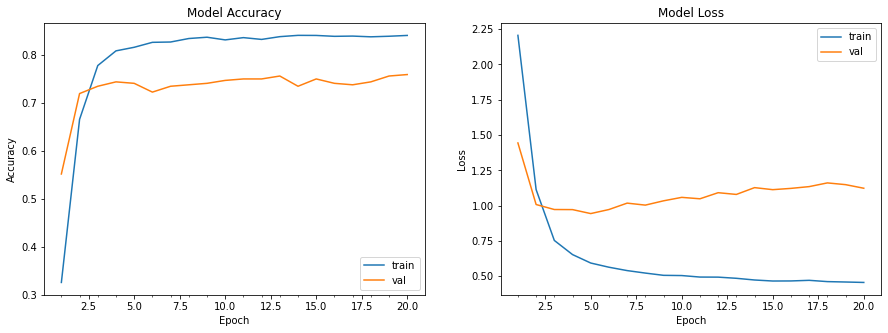

In [89]:
plot_model_history(history_10)

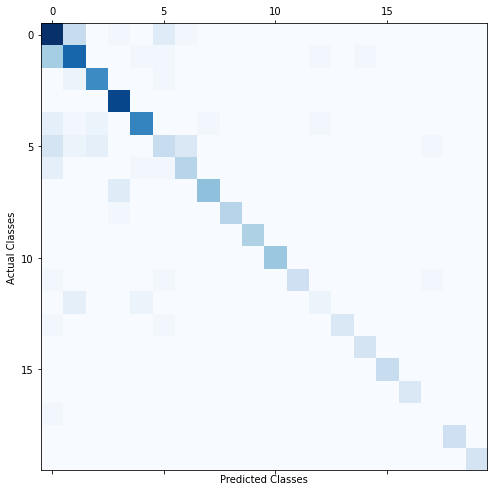

In [90]:
confusion_matrix(model_10)

### 11. 1D ConvNet with Normalization and Bias
Let's see how our ConvNet responds to adding our bias weights

In [91]:
model_11 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                              ,output_dim=64)
                              ,tf.keras.layers.Conv1D(64, 2, activation='relu',padding = 'same', kernel_regularizer=regularizers.l2(0.0001))
                              ,tf.keras.layers.MaxPooling1D(2)
                              ,tf.keras.layers.Dropout(0.25)
                              ,tf.keras.layers.Conv1D(32, 2, activation='relu',padding = 'same', kernel_regularizer=regularizers.l2(0.0001))
                              ,tf.keras.layers.Dropout(0.25)
                              ,tf.keras.layers.GlobalMaxPooling1D()
                              ,tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001))
                              ,tf.keras.layers.Dense(20,activation='softmax')
])

In [92]:
history_11, time_11 = compile_and_fit(model_11, weights = class_weight)

Epoch 1/20
185/185 [==============================] - 2s 5ms/step - loss: 2.9488 - accuracy: 0.0972 - val_loss: 1.9994 - val_accuracy: 0.4817
Epoch 2/20
185/185 [==============================] - 1s 4ms/step - loss: 1.5829 - accuracy: 0.4748 - val_loss: 1.2063 - val_accuracy: 0.6524
Epoch 3/20
185/185 [==============================] - 1s 4ms/step - loss: 0.9258 - accuracy: 0.6685 - val_loss: 1.0849 - val_accuracy: 0.6860
Epoch 4/20
185/185 [==============================] - 1s 4ms/step - loss: 0.7070 - accuracy: 0.7507 - val_loss: 0.9854 - val_accuracy: 0.7256
Epoch 5/20
185/185 [==============================] - 1s 4ms/step - loss: 0.5983 - accuracy: 0.7712 - val_loss: 1.0469 - val_accuracy: 0.7043
Epoch 6/20
185/185 [==============================] - 1s 4ms/step - loss: 0.5515 - accuracy: 0.7833 - val_loss: 1.0212 - val_accuracy: 0.7012
Epoch 7/20
185/185 [==============================] - 1s 4ms/step - loss: 0.5207 - accuracy: 0.8013 - val_loss: 1.0505 - val_accuracy: 0.7134
Epoch 

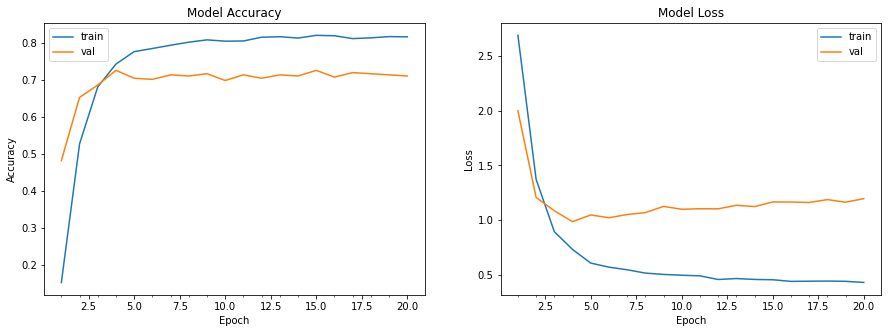

In [93]:
plot_model_history(history_11)

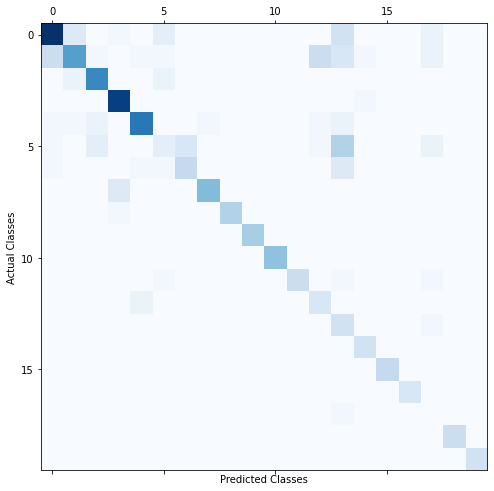

In [94]:
confusion_matrix(model_11)

# Evaluation
Wrapping up and comparing the results of our experiments

## Checking additional metrics
So far I've focused on accuracy, but there are other methods of scoring a classification model. I'll look at my models from two new directions:
1. Deeper dive on two of my models (checking f1, recall, precision)
2. Looking at how accurate the models were by seeing if the correct label fell in the top n predictions

In [95]:
# Checking additional metrics for our baseline RNN (model 1)
test_predictions_1 = np.argmax(model_1.predict(X_test), axis=-1)

print(classification_report(Y_test, test_predictions_1, target_names = list(d.keys())))

                     precision    recall  f1-score   support

     Alcohol & Bars       0.74      0.63      0.68        41
        Restaurants       0.65      0.59      0.62        44
          Groceries       0.79      0.79      0.79        33
           Transfer       0.87      0.96      0.91        27
         Gas & Fuel       0.89      0.89      0.89        27
               Gift       0.26      0.71      0.38        14
           Shopping       0.75      0.38      0.50        24
Credit Card Payment       1.00      0.77      0.87        13
    Interest Income       1.00      0.93      0.97        15
           Paycheck       1.00      0.87      0.93        15
          Utilities       1.00      0.90      0.95        10
   Home Improvement       1.00      0.75      0.86         4
          Fast Food       0.50      0.42      0.45        12
           Clothing       0.31      0.62      0.42         8
             Income       0.75      0.90      0.82        10
       Student Loan    

Then comparing that to one of the best model:

In [117]:
# Then comparing that to our larger ConvNet (model 10)
test_predictions_10 = np.argmax(model_10.predict(X_test), axis=-1)

print(classification_report(Y_test, test_predictions_10, target_names = list(d.keys())))

                     precision    recall  f1-score   support

     Alcohol & Bars       0.76      0.83      0.79        41
        Restaurants       0.69      0.80      0.74        44
          Groceries       0.69      0.82      0.75        33
           Transfer       0.87      0.96      0.91        27
         Gas & Fuel       0.92      0.89      0.91        27
               Gift       0.46      0.43      0.44        14
           Shopping       0.65      0.62      0.64        24
Credit Card Payment       1.00      0.77      0.87        13
    Interest Income       1.00      0.93      0.97        15
           Paycheck       1.00      0.87      0.93        15
          Utilities       1.00      1.00      1.00        10
   Home Improvement       1.00      0.75      0.86         4
          Fast Food       0.50      0.17      0.25        12
           Clothing       0.75      0.75      0.75         8
             Income       0.69      0.90      0.78        10
       Student Loan    

Predicting the correct category is important but maybe for the ones it mislabeled the second guess was correct?

Let's take a look at what percent the correct label falls into the top n categories.

In [97]:
# Creating a function to determine what % of records fall
# in the top n categories based on our models predictions on
# the validation dataset

def top_n_acc(model, n=5):
  y_pred = model.predict(X_validate)
  y_true = Y_validate

  m = tf.keras.metrics.sparse_top_k_categorical_accuracy(y_true, y_pred, k=n)
  # Number of records in top n / total number of records
  return sum(m.numpy())/len(Y_validate)

Top 5:

In [98]:
# Comparing the accuracy of all of our models on top 5 categories

for i in range(1,12):
    print("Model_"+str(i) + ":    ", eval("top_n_acc(model_" + str(i) + ", n=5)"))

Model_1:     0.9176829268292683
Model_2:     0.9115853658536586
Model_3:     0.9329268292682927
Model_4:     0.899390243902439
Model_5:     0.9603658536585366
Model_6:     0.926829268292683
Model_7:     0.9420731707317073
Model_8:     0.926829268292683
Model_9:     0.9420731707317073
Model_10:     0.9542682926829268
Model_11:     0.9298780487804879


Top 3:

In [99]:
# Comparing the accuracy of all of our models on top 3 categories

for i in range(1,12):
    print("Model_"+str(i) + ":    ", eval("top_n_acc(model_" + str(i) + ", n=3)"))

Model_1:     0.8841463414634146
Model_2:     0.8689024390243902
Model_3:     0.8963414634146342
Model_4:     0.8536585365853658
Model_5:     0.8902439024390244
Model_6:     0.8841463414634146
Model_7:     0.8841463414634146
Model_8:     0.8932926829268293
Model_9:     0.926829268292683
Model_10:     0.9115853658536586
Model_11:     0.8689024390243902


Top 2:

In [100]:
# Comparing the accuracy of all of our models on top 2 categories
print("Baseline:   ", len(df.loc[df.loc[:, 'Label'].isin([0,1]), :])/len(df))
for i in range(1,12):
    print("Model_"+str(i) + ":    ", eval("top_n_acc(model_" + str(i) + ", n=2)"))

Baseline:    0.2868677635588056
Model_1:     0.8353658536585366
Model_2:     0.8475609756097561
Model_3:     0.8780487804878049
Model_4:     0.8170731707317073
Model_5:     0.875
Model_6:     0.8597560975609756
Model_7:     0.8353658536585366
Model_8:     0.8597560975609756
Model_9:     0.8810975609756098
Model_10:     0.8689024390243902
Model_11:     0.8414634146341463


## Comparing Model Results
In this section we'll compile the results of all of our models so we can easily compare them all across the following metrics:
* Time to train
* Training accuracy & loss
* Test accuracy & loss

In [101]:
# Running a loop to get the accuracy of all of our models on the training and test sets

train_acc = []
test_acc = []
test_loss = []
total_time = []
x = []

for i in range(1,12):
    x.append(i)
    total_time.append(eval("time_" + str(i)))
    test_l, test_a = eval("model_" + str(i) + ".evaluate(x = X_test, y = Y_test)")
    train_l, train_a = eval("model_" + str(i) + ".evaluate(x = X_train, y = Y_train)")
    test_acc.append(test_a)
    test_loss.append(test_l)
    train_acc.append(train_a)


185/185 [==============================] - 0s 1ms/step - loss: 0.4715 - accuracy: 0.8365


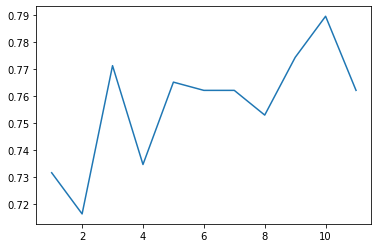

In [102]:
# Plotting Test Accuracy
plt.plot(x, test_acc)

(0.6, 0.9)

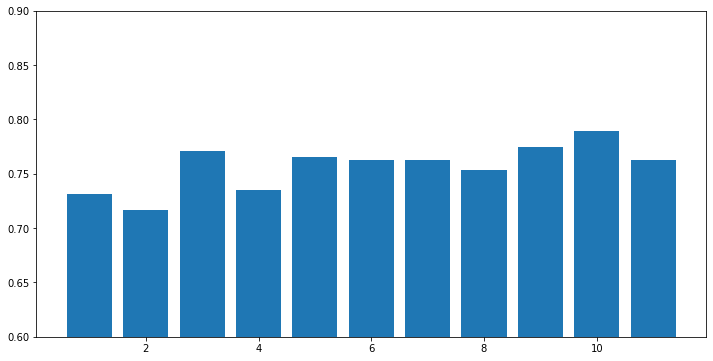

In [123]:
# Plotting Test Accuracy
# WARNING: Y AXIS TRUNCATED

fig, ax = plt.subplots(figsize=(12, 6))

x = x
y = test_acc

ax.bar(x,y)

plt.ylim([0.6, 0.9])

(0.8, 1.2)

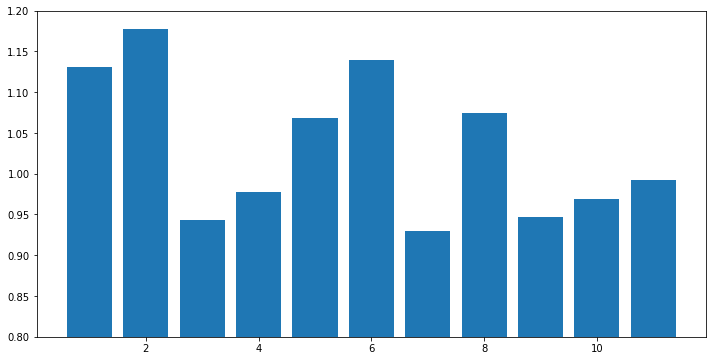

In [126]:
# Plotting Test Loss
# WARNING: Y AXIS TRUNCATED
fig, ax = plt.subplots(figsize=(12, 6))

x = x
y = test_loss

ax.bar(x,y)

plt.ylim([0.8, 1.2])

In [104]:
# Checking Times
for item in range(len(total_time)):
  print("Model ", x[item], ":\t", total_time[item])

Model  1 :	 0:00:12.139209
Model  2 :	 0:00:11.777414
Model  3 :	 0:00:13.037772
Model  4 :	 0:00:14.269964
Model  5 :	 0:00:33.892042
Model  6 :	 0:00:30.017588
Model  7 :	 0:00:29.610315
Model  8 :	 0:02:04.651528
Model  9 :	 0:00:14.920172
Model  10 :	 0:00:20.179333
Model  11 :	 0:00:16.095545


In [105]:
print("Model with Max Accuracy: \t", np.argmax(test_acc, axis=-1)+1)
print("Model with Min Loss: \t\t", np.argmin(test_loss, axis=-1)+1)
print("Model with Fastest Time: \t", np.argmin(total_time, axis=-1)+1)


Model with Max Accuracy: 	 10
Model with Min Loss: 		 7
Model with Fastest Time: 	 2


Now let's look at all of the models together in a tabular format across all metrics:
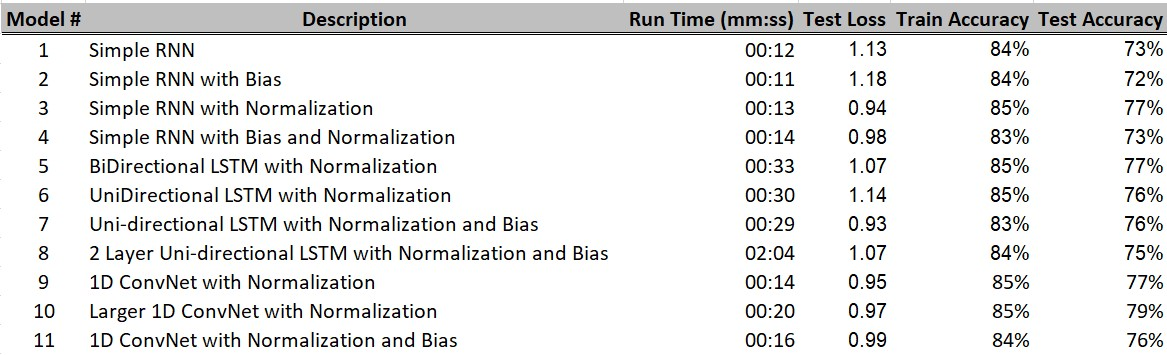

There's a lot to unpack here. Please refer to the accompanying write up for my thoughts on the results and findings of these experiments.